In [118]:
import numpy as np
import pandas as pd
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import phase_ucb_acq1, generate1, log_likelihood, get_likelihood_utility

In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward

In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

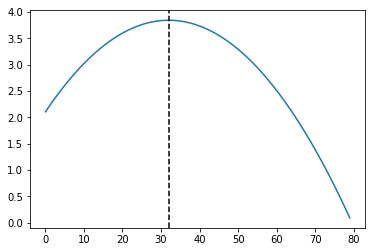

In [4]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

## Strategies

In [80]:
steepness_params = np.array([0, 100])
x_midpoint_params = np.array([10, 20])
yscale_params = np.array([0, 1])
temp_params = np.array([.01, .01])
trials = np.arange(20)
titles = ['Pure Exploit', 'Pure Explore']

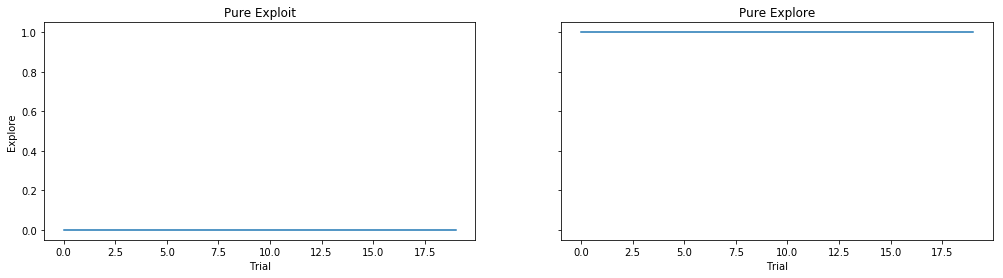

In [6]:
explore = (1 - 1. / (1 + yscale_params[:,None] * np.exp(-steepness_params[:,None] * (trials - x_midpoint_params[:,None]))))
fig, axes = plt.subplots(1, len(steepness_params), sharex=True, sharey=True, figsize=(17, 4))
for i in range(len(axes)):
    axes[i].plot(explore[i])
    axes[i].set_title(titles[i])
    if i == 0:
        axes[i].set_ylabel('Explore')
    axes[i].set_xlabel('Trial')

In [7]:
true_params = {'steepness': steepness_params, 'x_midpoint': x_midpoint_params,
                                  'temperature': temp_params, 'yscale': yscale_params}

In [8]:
data = generate1(phase_ucb_acq1, true_params, neg_quad_kern, neg_quad, 10, 20, 2, np.array([.5, .5]))

In [38]:
actions = data[:,8,:].argmax(axis=1)

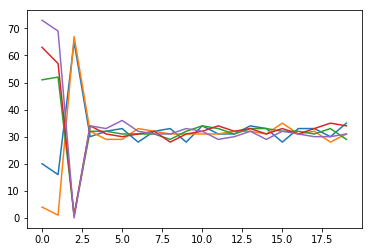

In [39]:
plt.plot(actions[:5].T);

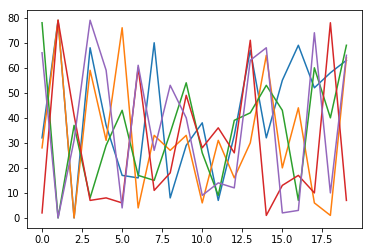

In [40]:
plt.plot(actions[5:].T);

## No Mixture

In [14]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', log_likelihood(data, phase_ucb_acq1, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, np.array([1.])))
    no_mix_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:27<00:00, 103.52draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5905737766509269, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


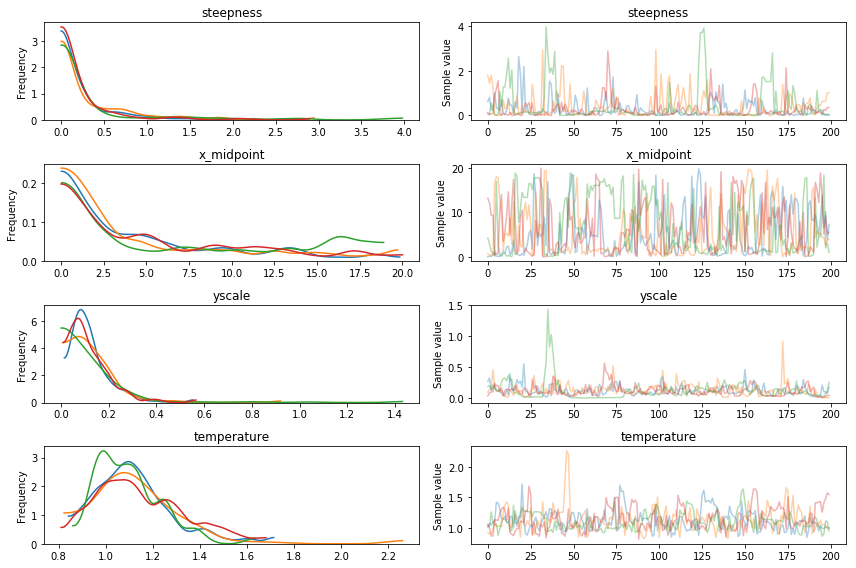

In [15]:
pm.traceplot(no_mix_trace);

## Fixed Mixture

In [16]:
k=2
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=k)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=k)
    yscale = pm.Gamma('yscale', 1., 1., shape=k)
    temperature = pm.Gamma('temperature', .1, .1, shape=k)
    param_mixture = pm.Dirichlet('param_mixture', a=np.ones(k))

    obs = pm.Potential('obs', log_likelihood(data, phase_ucb_acq1, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, k, param_mixture))
    fixed_mix_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [param_mixture, temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 2800/2800 [01:06<00:00, 42.33draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


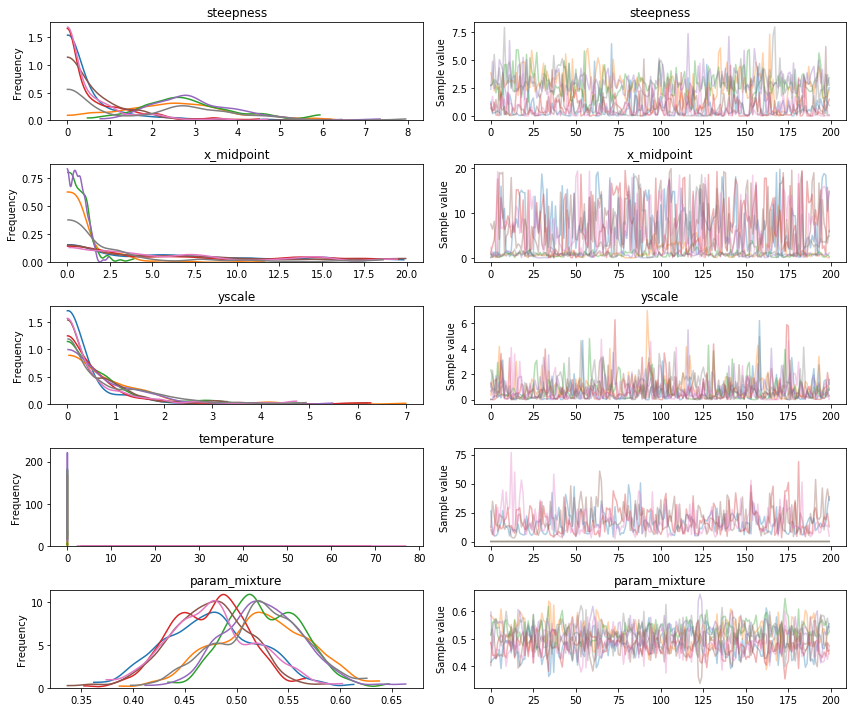

In [17]:
pm.traceplot(fixed_mix_trace);

In [18]:
a = data[:,5,:,:]
l, u = get_likelihood_utility(data, phase_ucb_acq1, true_params, 2, np.array([.5, .5]))
action_likelihood = l.transpose(1,3,0,2) * a[:,:,:,None]
c = np.log(action_likelihood.sum(axis=1)).sum(axis=1)
print (c)

[[25.68018975 17.95690969]
 [25.58276531 17.71796142]
 [25.67135742  5.29645346]
 [25.43527922 19.98203817]
 [24.77431203 19.43980135]
 [25.8402217  20.41405102]
 [25.78155644 20.32437083]
 [22.20405967 15.98035684]
 [24.58121991 18.26750987]
 [24.26248093 17.14398508]]


In [25]:
(c * np.array([.5, .5])).sum()

-inf

In [19]:
samples = np.array(fixed_mix_trace)

In [20]:
samples[-1]

{'param_mixture': array([0.4698255, 0.5301745]),
 'param_mixture_stickbreaking__': array([-0.12084483]),
 'steepness': array([0.00872082, 0.93402937]),
 'steepness_log__': array([-4.7420415, -0.0682474]),
 'temperature': array([4.70582142, 0.01407961]),
 'temperature_log__': array([ 1.54880034, -4.26302747]),
 'x_midpoint': array([14.72343121,  4.91443086]),
 'x_midpoint_interval__': array([ 1.02616415, -1.12156265]),
 'yscale': array([0.02092689, 0.29506764]),
 'yscale_log__': array([-3.8667205 , -1.22055068])}

In [19]:
last_sample_params = {p:v for p,v in samples[-1].items() if p in true_params}

In [20]:
last_sample_params

{'steepness': array([3.16891484, 1.27028165]),
 'temperature': array([0.93323897, 2.06213191]),
 'x_midpoint': array([0.21872223, 1.79612277]),
 'yscale': array([0.24882593, 0.10102474])}

In [23]:
l1, u1 = get_likelihood_utility(data, phase_ucb_acq1, last_sample_params, 2, samples[-1]['param_mixture'])
action_likelihood1 = l1.transpose(1,3,0,2) * a[:,:,:,None]
c1 = np.log(action_likelihood1.sum(axis=1)).sum(axis=1)
print (c1)

[[-75.27483251 -81.20394993]
 [-75.16220484 -81.92675483]
 [-77.04330504 -82.38048285]
 [-75.14925403 -81.62575861]
 [-74.92702048 -81.26530505]
 [-98.14128467 -89.88262668]
 [-92.46871375 -87.23357605]
 [-90.32117207 -86.02780949]
 [-93.49855652 -88.09167499]
 [-92.13380129 -87.07043371]]


In [26]:
(c1 * samples[-1]['param_mixture']).sum()

-844.17993493866

In [65]:
explore = (1 - 1. / (1 + np.array([samples[-1]['yscale'][0]])[:,None]
                     * np.exp(-np.array([samples[-1]['steepness'][0]])[:,None]
                              * (trials - np.array([samples[-1]['x_midpoint'][0]])[:,None]))))

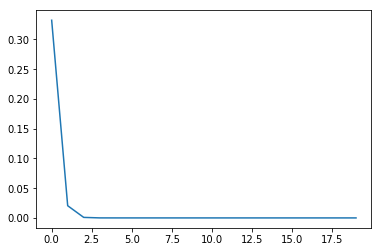

In [68]:
plt.plot(explore.ravel())

In [69]:
explore.ravel()

array([3.32280295e-01, 2.04962434e-02, 8.79111523e-04, 3.69970960e-05,
       1.55575354e-06, 6.54182942e-08, 2.75078738e-09, 1.15668364e-10,
       4.86366503e-12, 2.04503081e-13, 8.65973959e-15, 4.44089210e-16,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

## Infinite Mixture

In [21]:
k=30

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [22]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=k)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=k)
    yscale = pm.Gamma('yscale', 1., 1., shape=k)
    temperature = pm.Gamma('temperature', .1, .1, shape=k)
    
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=k)
    w = pm.Deterministic('w', stick_breaking(beta))

    obs = pm.Potential('obs', log_likelihood(data, phase_ucb_acq1, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, k, w))
    inf_mix_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 2800/2800 [1:52:53<00:00,  4.48s/draws]    
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8952893888856314, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


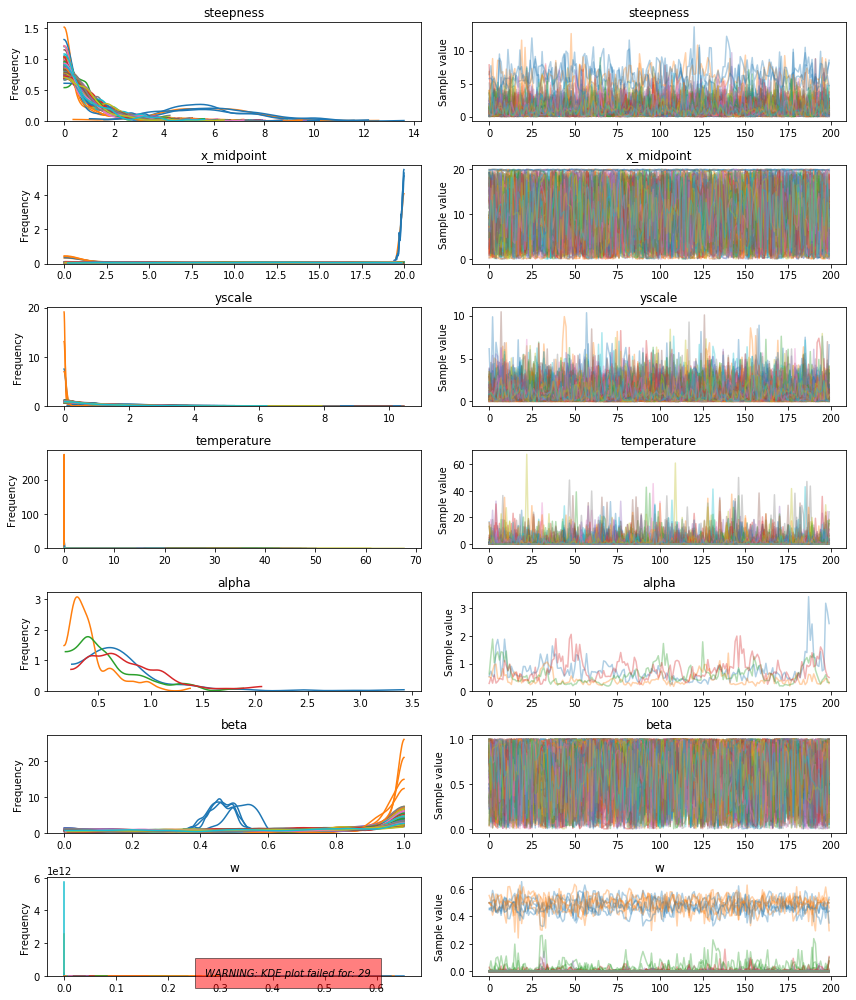

In [23]:
pm.traceplot(inf_mix_trace);

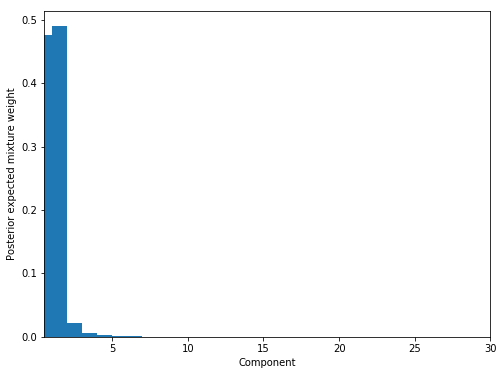

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(k) + 1

ax.bar(plot_w - 0.5, inf_mix_trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, k);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [26]:
inf_mix_trace['w'].mean(axis=0)[:2]

array([0.47557325, 0.48985359])

In [31]:
steepness1 = inf_mix_trace['steepness'].mean(axis=0)[:2]

In [32]:
x_midpoint1 = inf_mix_trace['x_midpoint'].mean(axis=0)[:2]

In [33]:
yscale1 = inf_mix_trace['yscale'].mean(axis=0)[:2]

In [34]:
inf_mix_trace['temperature'].mean(axis=0)[:2]

array([0.03400636, 0.0200056 ])

In [103]:
def phase_ucb_clusters(trace, threshold):
    
    mean_weights = trace['w'].mean(axis=0)
    idx = np.argwhere(mean_weights>=threshold).ravel()
    samples = np.array([[s['steepness'], s['x_midpoint'], s['yscale']] for s in np.array(trace)])[:,:,idx]
    
    position = trials[:,None,None] - samples[:,1,:]
    growth = np.exp(-samples[:,0,:] * position)
    denom = 1 + samples[:,2,:] * growth
    e = 1 - 1. / denom

    mean_e = e.mean(axis=1)
    std_e = e.std(axis=1)
    return mean_e, std_e

In [124]:
def plot_phase_ucb_clusters(mean_e, std_e):
    
    mean_e = mean_e.T
    std_e = std_e.T
    colors = np.array(sns.color_palette("hls", mean_e.shape[0]).as_hex())
    upper = (mean_e + 2 * std_e).clip(min=0, max=1)
    lower = (mean_e - 2 * std_e).clip(min=0, max=1)
    for i in range(len(mean_e)):
        plt.plot(mean_e[i], color=colors[i])
        plt.fill_between(np.arange(len(mean_e[i])), lower[i], upper[i], color=colors[i], alpha=.5)
    

In [125]:
mean_e, std_e = phase_ucb_clusters(inf_mix_trace, .4)

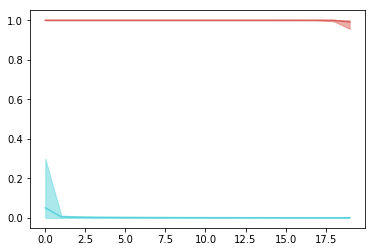

In [126]:
plot_phase_ucb_clusters(mean_e, std_e)

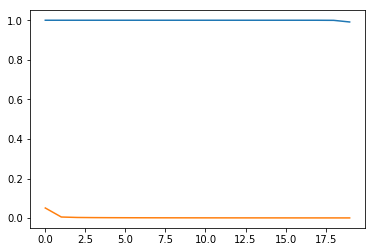

In [106]:
plt.plot(mean_e);

In [113]:
upper = (mean_e + 2 * std_e).clip(min=0, max=1)
lower = (mean_e - 2 * std_e).clip(min=0, max=1)

In [119]:
lower.shape

(20, 2)